In [ ]:
#importing all the libraries
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [ ]:
#loading the data
df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
df = df.loc[(df['location'] == 'United Kingdom')]

df_cases = df['new_cases']
df_deaths = df['new_deaths']

seq_cases, seq_deaths = df_cases.values, df_deaths.values
seq_cases, seq_deaths = seq_cases.astype('float32'), seq_deaths.astype('float32')
seq_cases, seq_deaths = seq_cases.reshape(-1, 1), seq_deaths.reshape(-1, 1)

In [ ]:
#normalizing the data
# scaler = MinMaxScaler(feature_range=(0, 1))
# seq_cases = scaler.fit_transform(seq_cases)
# seq_deaths = scaler.fit_transform(seq_deaths)

In [ ]:
#function that splits the data into input and output
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
#preparing the dataset
dataset = hstack((seq_cases, seq_deaths))

n_steps_in, n_steps_out = 14, 7

X, y = split_sequences(dataset, n_steps_in, n_steps_out)

n_features = X.shape[2]

In [ ]:
# define the LSTM model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')

In [ ]:
#train the model
model.fit(X, y, epochs=10, verbose=0)

In [ ]:
#make the prediction
dataframe = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
dataframe = dataframe.loc[(dataframe['location'] == 'United Kingdom')  ]

pred = dataframe.loc[(dataframe['date'] > '2020-05-29')]

pred = pred[['new_cases', 'new_deaths']]
pred_input = array(pred)
pred_input = pred_input.reshape((1, n_steps_in, n_features))

prediction = model.predict(pred_input, verbose=0)

pred_array = prediction[0, :]
data = pd.DataFrame({'new_cases': pred_array[:, 0], 'new_deaths': pred_array[:, 1]})
print(pred)
print(data)


       new_cases  new_deaths
22099       2095         324
22100       1604         215
22101       1936         113
22102       1570         556
22103       1653         324
22104       1871         359
22105       1805         176
22106       1650         357
22107       1557         204
22108       1326          77
22109       1205          55
22110       1741         286
22111       1003         245
22112       1266         151
     new_cases  new_deaths
0   315.138184   76.012115
1   648.624023  100.434669
2   956.831482  140.761734
3  1305.216309  198.161362
4  1547.638550  275.918488
5  1848.440063  286.700317
6  2192.945068  348.274658


In [ ]:
#preparing the data for plotting
train_cases = dataframe[['new_cases']]
train_cases = train_cases.to_numpy()
train_deaths = dataframe[['new_deaths']]
train_deaths = train_deaths.to_numpy()

prediction_cases = data[['new_cases']]
prediction_cases = prediction_cases.to_numpy()
prediction_deaths = data[['new_deaths']]
prediction_deaths = prediction_deaths.to_numpy()

total_cases = np.concatenate((train_cases, prediction_cases), axis=0)
total_deaths = np.concatenate((train_deaths, prediction_deaths), axis=0)

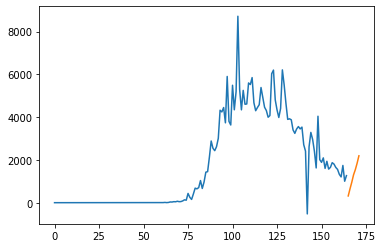

In [ ]:
#plot the numer of cases
train_casesPlot = np.empty_like(total_cases)
train_casesPlot[:, :] = np.nan
train_casesPlot[:len(train_cases), : ] = train_cases

prediction_casesPlot = np.empty_like(total_cases)
prediction_casesPlot[:, :] = np.nan
prediction_casesPlot[len(train_cases):len(prediction_cases) + len(train_cases), :] = prediction_cases

plt.plot(train_casesPlot)
plt.plot(prediction_casesPlot)
plt.show()

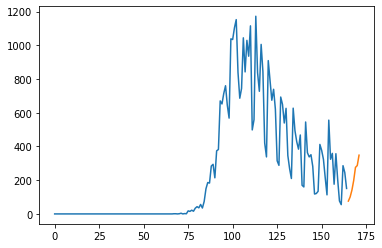

In [ ]:
#plot the number of deaths
train_deathsPlot = np.empty_like(total_deaths)
train_deathsPlot[:, :] = np.nan
train_deathsPlot[:len(train_deaths), : ] = train_deaths

prediction_deathsPlot = np.empty_like(total_deaths)
prediction_deathsPlot[:, :] = np.nan
prediction_deathsPlot[len(train_deaths):len(prediction_deaths) + len(train_deaths), :] = prediction_deaths

plt.plot(train_deathsPlot)
plt.plot(prediction_deathsPlot)
plt.show()